In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from src.cmesrc.config import CMESRC_DB

# Import matplotlib patch

from matplotlib.patches import Patch

In [2]:
colors = {
    "yellow": "#EBB53D",
    "green": "#3B916D",
    "orange": "#DE8945",
    "blue": "#39909E",
    "red": "#EB4336",
    "black": "#231F20",
    "beige": "#EFEADF",
    "leafgreen": "#8CA530",
    "softmint": "#C3D9BF"
}

cm_to_inch = 1/2.54

onecolumn = 9.4 * cm_to_inch
twocolumn = 18.3 * cm_to_inch

# Three row figure
# Set font to FiraCode NF (can remove if you don't have the font, not essential)
plt.rcParams["font.family"] = "FiraCode Nerd Font"

# Set font size to 10
plt.rcParams["font.size"] = 10

# Set all base black colors to my colors["black"]
plt.rcParams["text.color"] = colors["black"]
plt.rcParams["axes.labelcolor"] = colors["black"]
plt.rcParams["xtick.color"] = colors["black"]
plt.rcParams["ytick.color"] = colors["black"]
plt.rcParams["axes.edgecolor"] = colors["black"]

# To darken or lighten a color. If amount positive, lighten, if negative, darken
def darken_lighten_hex_color(color, amount=0):
    # Ensure amount is between -1 and 1
    amount = max(-1, min(1, amount))
    
    # Remove '#' if present
    color = color.lstrip("#")
    
    # Convert hex to RGB
    rgb = [int(color[i:i+2], 16) for i in (0, 2, 4)]
    
    for i in range(3):
        if amount > 0:
            # Lighten: interpolate towards 255 (white)
            rgb[i] = int(rgb[i] + (255 - rgb[i]) * amount)
        else:
            # Darken: interpolate towards 0 (black)
            rgb[i] = int(rgb[i] * (1 + amount))
    
    # Ensure values are within 0-255 range
    rgb = [max(0, min(255, x)) for x in rgb]
    
    return "#{:02x}{:02x}{:02x}".format(*rgb)


In [3]:
conn = sqlite3.connect("../data/processed/final_results/cmesrcV3.db")
cur = conn.cursor()

In [4]:
# Let's see how many CMEs there were in our time period
study_start, study_end = cur.execute("SELECT MIN(Timestamp), MAX(Timestamp) FROM PROCESSED_HARPS_BBOX").fetchone()

total_cmes = cur.execute("SELECT COUNT(*) FROM CMES WHERE cme_date BETWEEN ? AND ?", (study_start, study_end)).fetchone()[0]
matched_cmes = cur.execute("SELECT COUNT(*) FROM FINAL_CME_HARP_ASSOCIATIONS").fetchone()[0]

print(f"Out of {total_cmes} CMEs, {matched_cmes} were matched to a HARP region. That's {matched_cmes/total_cmes*100:.2f}%, when we would expect 50%")

Out of 14507 CMEs, 1132 were matched to a HARP region. That's 7.80%, when we would expect 50%


Text(0, 0.5, 'Number of CMEs')

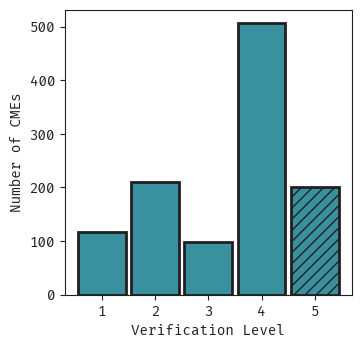

In [5]:
# Let's make a plot of the distribution of matches per verification levels

fig, ax = plt.subplots(figsize=(onecolumn, onecolumn))

# Get the data
data = cur.execute("SELECT verification_score FROM FINAL_CME_HARP_ASSOCIATIONS").fetchall()

# Need to flatten the list of tuples
data = [x[0] for x in data]

# We need the bins to cover integers from 1 to 5
bins = np.arange(0.5, 6.5, 1)

# Make the plot, separating the bars a bit
_, _, bars = ax.hist(data, color=colors["blue"], edgecolor=colors["black"], linewidth=2, rwidth=0.9, align="mid", bins=bins)

# For the last bar, add a hatch
bars[-1].set_hatch("///")

# Set the labels
ax.set_xlabel("Verification Level")
ax.set_ylabel("Number of CMEs")

[245 115  69  19   6] [2049  531  165   41    7]


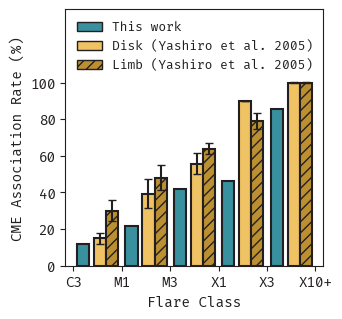

In [6]:
from matplotlib.patches import Patch

# Now let's try to make it closer to Yashiro 2005

fig, ax = plt.subplots(figsize=(0.9 * onecolumn, 0.9 * onecolumn))

data = pd.read_sql("""WITH flares_with_cmes AS (
SELECT F.flare_id FROM FLARES F
INNER JOIN CMES_HARPS_EVENTS CHE ON F.flare_id = CHE.flare_id
INNER JOIN FINAL_CME_HARP_ASSOCIATIONS FCHE ON CHE.cme_id = FCHE.cme_id
                   )
SELECT F.flare_class_score,
CASE WHEN F.flare_id IN flares_with_cmes THEN 1 ELSE 0 END AS has_cme FROM FLARES F
WHERE F.flare_date BETWEEN ? AND ?
                   """, conn, params=(study_start, study_end))

data

# Now let's redo the bins by Yashiro

bins = [23, 29.9, 31 ,32.9, 33, 39.9, 41, 42.9, 43, 100]

yashiro_disk_means = [14.9, 39.4, 55.7, 89.9, 100]
yashiro_limb_means = [30.0, 48, 63.9, 79.1, 100]
yashiro_disk_std = [2.8, 7.7, 5.7, 0.1, 0.1]
yashiro_limb_std = [5.7, 6.8, 2.9, 4.2, 0.1]

# Now bin on one hand how many ones with CME per bin and on the other, how many in total
n_with_cme = []
n_total = []

for i in range(len(bins) - 1):
    n_with_cme.append(data.query(f"flare_class_score >= {bins[i]} and flare_class_score < {bins[i+1]}")["has_cme"].sum())
    n_total.append(data.query(f"flare_class_score >= {bins[i]} and flare_class_score < {bins[i+1]}")["has_cme"].count())

n_with_cme = np.array(n_with_cme)
n_total = np.array(n_total)

# Now we only care about the entries with index 0, 2, 4, 6, 8
n_with_cme = n_with_cme[[0, 2, 4, 6, 8]]
n_total = n_total[[0, 2, 4, 6, 8]]

print(n_with_cme, n_total)

percentages = n_with_cme / n_total * 100

xpos = np.arange(5)
width = 0.25

mypos = xpos - width - 0.05
ax.bar(mypos, percentages, color=colors["blue"], edgecolor=colors["black"], linewidth=1.5, width=width, align="center", zorder = 10)

# Now let's plot the Yashiro means and stds behind
disk_pos = xpos + 0.05
limb_pos = xpos + width + 0.05

lighter_yellow = darken_lighten_hex_color(colors["yellow"], 0.2)
darker_yellow = darken_lighten_hex_color(colors["yellow"], -0.2)

ax.bar(disk_pos, yashiro_disk_means, color=lighter_yellow, edgecolor=colors["black"], linewidth=1.5, width=width, align="center", zorder=5, hatch="")
ax.bar(limb_pos, yashiro_limb_means, color=darker_yellow, edgecolor=colors["black"], linewidth=1.5, width=width, align="center", zorder=5, hatch="///")

# Add the error bars for yashiro

ax.errorbar(disk_pos, yashiro_disk_means, yashiro_disk_std, fmt="none", ecolor=colors["black"], zorder=15, capsize=3)
ax.errorbar(limb_pos, yashiro_limb_means, yashiro_limb_std, fmt="none", ecolor=colors["black"], zorder=15, capsize=3)


# Now let's label like Yashiro

ax.set_xticks(np.arange(-0.5, 5.5, 1))
ax.set_xticklabels(["C3", "M1", "M3", "X1", "X3", "X10+"])

# Now legend on top left, manually

# Blue bar is this work, yellow without hash if Yashiro 2005 on disk, yellow with hash if Yashiro 2005 on limb
legend_elements = [
    Patch(facecolor=colors["blue"], edgecolor=colors["black"], label="This work"),
    Patch(facecolor=lighter_yellow, edgecolor=colors["black"], label="Disk (Yashiro et al. 2005)", hatch=""),
    Patch(facecolor=darker_yellow, edgecolor=colors["black"], hatch="///", label="Limb (Yashiro et al. 2005)")
]

ax.legend(handles=legend_elements, loc="upper left", fontsize=9, frameon=False)

ax.set_ylim(0, 140)

ax.set_yticks(np.arange(0, 120, 20))

ax.set_xlabel("Flare Class")
ax.set_ylabel("CME Association Rate (%)")

plt.savefig("./flare_association_rate.pdf", bbox_inches="tight")

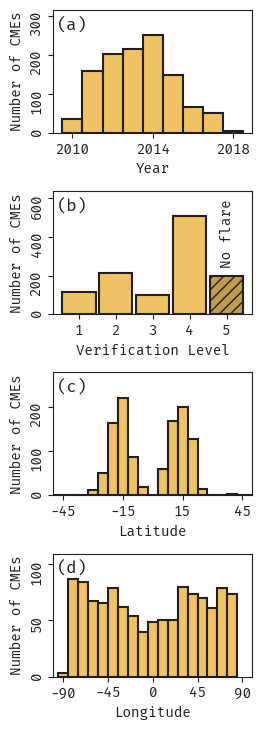

In [7]:
# Now let's do a bigger plot with several statistics. It will have 4 of them

# Ensure square aspect ratio of subplots
fig, ax = plt.subplots(4, figsize=(onecolumn, 2 * onecolumn), sharey=False)

linewidth = 1.5
main_color = darken_lighten_hex_color(colors["yellow"], 0.2)
darker_main_color = darken_lighten_hex_color(main_color, -0.2)

# First plot will be the distribution of the number of matches over time

plot1_data = pd.read_sql("SELECT C.cme_date FROM FINAL_CME_HARP_ASSOCIATIONS FCHE INNER JOIN CMES C ON FCHE.cme_id = C.cme_id", conn)

plot1_data["cme_date"] = pd.to_datetime(plot1_data["cme_date"])
plot1_data["year"] = plot1_data["cme_date"].dt.year

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]
ax4 = ax[3]

ax1.hist(plot1_data["year"], bins=np.arange(2009.5, 2019.5), color=main_color, edgecolor=colors["black"], linewidth=linewidth, align="mid")

plot1_ticks = np.arange(2010, 2019, 4)

ax1.set_xticks(plot1_ticks)

ax1.set_xlabel("Year")
ax1.set_ylabel("Number of CMEs")


# Second one will be the distribution of the verification levels

# Get the data
plot2_data = cur.execute("SELECT verification_score FROM FINAL_CME_HARP_ASSOCIATIONS").fetchall()

# Need to flatten the list of tuples
plot2_data = [x[0] for x in plot2_data]

# We need the bins to cover integers from 1 to 5
plot2_bins = np.arange(0.5, 6.5, 1)

# Make the plot, separating the bars a bit
_, _, bars = ax2.hist(plot2_data, color=main_color, edgecolor=colors["black"], linewidth=linewidth, rwidth=0.9, align="mid", bins=plot2_bins)


# Set bar color to darker but keep the rest of the formatting
bars[-1].set_color(darker_main_color)
bars[-1].set_edgecolor(colors["black"])

# For the last bar, add a hatch
bars[-1].set_hatch("///")

# Put on top of bar 2 text saying "No flare" 
bar_height = bars[-1].get_height()
ax2.text(5, bar_height * 1.2 , "No flare", ha="center", rotation=90, va="bottom")

plot2_ticks = np.arange(1, 6, 1)

ax2.set_xticks(plot2_ticks)


# Set the labels
ax2.set_xlabel("Verification Level")
ax2.set_ylabel("Number of CMEs")


# Third plot is distribution of latitude

plot3_data = pd.read_sql("""SELECT (PHBB.LATDTMIN + PHBB.LATDTMAX) / 2 AS latitude FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN CMES C ON FCHA.cme_id = C.cme_id
INNER JOIN PROCESSED_HARPS_BBOX PHBB ON FCHA.harpnum = PHBB.harpnum AND C.image_timestamp = PHBB.Timestamp
                         """, conn)

# Bins from -90 to 90 in steps of 10

plot3_bins = np.arange(-52.5, 62.5, 5)

ax3.hist(plot3_data["latitude"], bins=plot3_bins, color=main_color, edgecolor=colors["black"], linewidth=linewidth, align="mid")

plot3_ticks = np.arange(-45, 60, 30)

ax3.set_xticks(plot3_ticks)
ax3.set_xlim(-50, 50)

ax3.set_xlabel("Latitude")
ax3.set_ylabel("Number of CMEs")


# Fourth plot is distribution of longitude
plot4_data = pd.read_sql("""SELECT (PHBB.LONDTMIN + PHBB.LONDTMAX) / 2 AS latitude FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN CMES C ON FCHA.cme_id = C.cme_id
INNER JOIN PROCESSED_HARPS_BBOX PHBB ON FCHA.harpnum = PHBB.harpnum AND C.image_timestamp = PHBB.Timestamp
                         """, conn)

plot4_bins = np.arange(-95, 95, 10)

ax4.hist(plot4_data["latitude"], bins=plot4_bins, color=main_color, edgecolor=colors["black"], linewidth=linewidth, align="mid")

# Set ticks
plot4_ticks = np.arange(-90, 100, 45)

ax4.set_xticks(plot4_ticks)
ax4.set_xlim(-100, 100)
ax4.set_xlabel("Longitude")
ax4.set_ylabel("Number of CMEs")

# Add a label a) b)... to each

for i, axi in enumerate(ax.flatten()):
    # Increase y limit by 10% to make space for the label
    ylim = axi.get_ylim()
    axi.set_ylim(ylim[0], ylim[1] * 1.2)

    axi.text(0.02, 0.95, f"({chr(97+i)})", transform=axi.transAxes, fontsize=12, va="top")

# Add borders and adjust aspect ratio
for axi in ax.flatten():
    # Set aspect ratio to 1
    axi.set_box_aspect(0.618)

# Make y ticks horizontal?
for axi in ax:
    axi.yaxis.set_tick_params(rotation=90, labelsize=10)

plt.tight_layout()

plt.savefig("./summary_statistics.pdf", bbox_inches="tight")

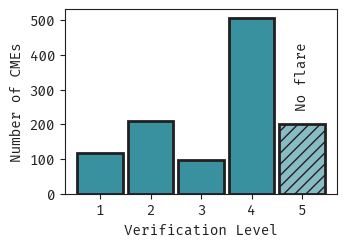

In [14]:
# Let's plot only the distribution of verification levels

fig, ax = plt.subplots(figsize=(0.95 * onecolumn, 0.95 * 0.681 * onecolumn))

# Get the data
data = cur.execute("SELECT verification_score FROM FINAL_CME_HARP_ASSOCIATIONS").fetchall()

# Need to flatten the list of tuples
data = [x[0] for x in data]

# We need the bins to cover integers from 1 to 5

bins = np.arange(0.5, 6.5, 1)

# Make the plot, separating the bars a bit

_, _, bars = ax.hist(data, color=colors["blue"], edgecolor=colors["black"], linewidth=2, rwidth=0.9, align="mid", bins=bins)

# For the last bar, add a hatch
bars[-1].set_hatch("///")

# And text saying "No flare"
bar_height = bars[-1].get_height()
ax.text(5, bar_height * 1.2 , "No flare", ha="center", rotation=90, va="bottom")

# And set its color to darker blue
darker_blue = darken_lighten_hex_color(colors["blue"], 0.4)

bars[-1].set_color(darker_blue)
# And put the edge color back to black
bars[-1].set_edgecolor(colors["black"])

# Set the labels
ax.set_xlabel("Verification Level")
ax.set_ylabel("Number of CMEs")

plt.savefig("./verification_level_distribution.pdf", bbox_inches="tight")


[ 63 273  96  60] [2771 1080  172   71]
[ 63 273  96  60] [2771 1080  172   71]
[ 63 273  96  60] [2771 1080  172   71]
[ 63 273  96  60] [2771 1080  172   71]


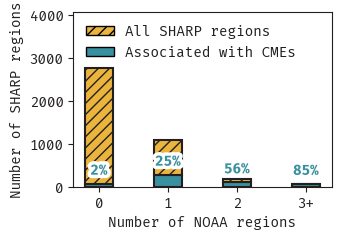

In [19]:
# Now let's look at how many regions we have per different number of NOAA

# In SQLITE, we can default the result to a number when the result is null using
# the following syntax:
#     SELECT COALESCE(COUNT(*),0)
import matplotlib.patheffects as PathEffects

n_noaas = pd.read_sql("""
SELECT H.harpnum, COALESCE((SELECT COUNT(*) FROM NOAA_HARPNUM_MAPPING NHM WHERE NHM.harpnum = H.harpnum), 0) AS n_noaa FROM HARPS H
WHERE H.start > ? AND H.start < ?
""", conn, params=(study_start, study_end))

data = pd.read_sql("""
WITH n_noaa AS (
SELECT H.harpnum, COALESCE((SELECT COUNT(*) FROM NOAA_HARPNUM_MAPPING NHM WHERE NHM.harpnum = H.harpnum), 0) AS n_noaa FROM HARPS H
)
SELECT FCHA.harpnum, N.n_noaa FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN n_noaa N ON N.harpnum = FCHA.harpnum
GROUP BY FCHA.harpnum
""", conn)

# Now let's bin our data
bins = np.arange(-0.5, 3.5, 1)
bins = np.concatenate([bins, [100]])

total_bin_counts = np.histogram(n_noaas['n_noaa'], bins)[0]
cme_bin_counts = np.histogram(data['n_noaa'], bins)[0]

# Now let's plot them

fig, ax = plt.subplots(figsize=(0.9 * onecolumn, 0.681 * 0.9 * onecolumn))

center_pos = np.arange(0, 4, 1)

widths = 0.4

cme_pos = center_pos 
total_pos = center_pos 

cme_bars = ax.bar(cme_pos, cme_bin_counts, color=colors["blue"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="")

# Now on top
diff_counts = total_bin_counts - cme_bin_counts
all_bars = ax.bar(x=cme_pos, bottom=cme_bin_counts, height=diff_counts, color=colors["yellow"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="///")

ax.set_xticks(center_pos)

# Now a legend on the top right

legend_handles = [
    Patch(facecolor=colors["yellow"], edgecolor="black", label="All SHARP regions", hatch="///"), 
    Patch(facecolor=colors["blue"], edgecolor="black", label="Associated with CMEs")
]

ax.legend(handles=legend_handles, loc="upper left", frameon=False)

ylim1 = ax.get_ylim()

ax.set_ylim(ylim1[0], ylim1[1] * 1.4)

ticklabels = center_pos.astype(str)
ticklabels[-1] = f"{center_pos[-1]}+"
ax.set_xticklabels(ticklabels)

ax.set_xlabel("Number of NOAA regions")
ax.set_ylabel("Number of SHARP regions")

for i, bar in enumerate(cme_bars):
    # Put % of matched on top of the bar
    height = bar.get_height()

    cme_count = cme_bin_counts[i]
    total_count = total_bin_counts[i]
    print(cme_bin_counts, total_bin_counts)

    percent = cme_count / total_count * 100
    # With no decimal
    percent_str = f"{percent:.0f}%"

    # Bold
    ax.text(bar.get_x() + bar.get_width() / 2, height + ylim1[1] * 0.05, percent_str, ha="center", va="bottom", color=colors["blue"], fontsize=10, path_effects=[PathEffects.withStroke(linewidth=5, foreground="white")], zorder=100, clip_on=False, weight="bold")

plt.savefig("./noaa_region_distribution.pdf", bbox_inches="tight")

[ -0.5   0.5   1.5   2.5 100. ] [0 1 2 3]
[ -0.5   0.5   1.5   2.5 100. ] [0 1 2 3]
[ -0.5   0.5   1.5   2.5 100. ] [0 1 2 3]
[ -0.5   0.5   1.5   2.5 100. ] [0 1 2 3]
[ -0.5   0.5   1.5   2.5 100. ] [0 1 2 3]


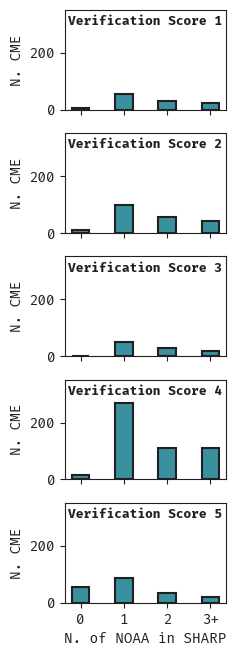

In [25]:
fig, axes = plt.subplots(5, figsize=(0.9 * onecolumn, 0.9 * 2 * onecolumn), sharex=True, sharey=True)

data = pd.read_sql("""
WITH n_noaa AS (
SELECT H.harpnum, COALESCE((SELECT COUNT(*) FROM NOAA_HARPNUM_MAPPING NHM WHERE NHM.harpnum = H.harpnum), 0) AS n_noaa FROM HARPS H
)
SELECT FCHA.*, N.n_noaa FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN n_noaa N ON N.harpnum = FCHA.harpnum
""", conn)

bins = np.arange(-0.5, 3.5, 1)
bins = np.append(bins, 100)

for i, verif_level in enumerate(sorted(data["verification_score"].unique())):
    ax = axes[i]
    single_data = data[data["verification_score"] == verif_level]["n_noaa"].to_numpy()

    # Now let's bin our data

    bin_counts = np.histogram(single_data, bins)[0]

    # Now let's plot them
    center_pos = np.arange(0, 4, 1)
    print(bins, center_pos)

    widths = 0.4

    ax.bar(center_pos, bin_counts, color=colors["blue"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="")

    ax.set_xticks(center_pos)

    # Now a legend on the top right

    ax.text(0.02, 0.95, f"Verification Score {int(verif_level)}", transform=ax.transAxes, fontsize=9, va="top", weight="bold")

    ylims = ax.get_ylim()

#    ax.set_ylim(ylims[0], ylims[1]*1.25)

    ticklabels = center_pos.astype("str")
    ticklabels[-1] = f"{ticklabels[-1]}+"

    ax.set_xticklabels(ticklabels)

    ax.set_box_aspect(0.618)
    ax.set_ylabel("N. CME")

axes[-1].set_xlabel("N. of NOAA in SHARP")
ylims = axes[-1].get_ylim()
axes[-1].set_ylim(ylims[0], ylims[1]*1.25)

plt.tight_layout()

plt.savefig("./noaa_region_distribution_per_verification.pdf", bbox_inches="tight")


(976, 3)


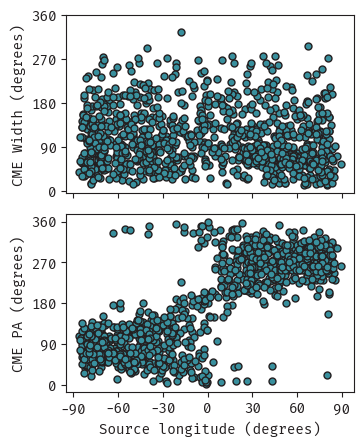

In [239]:
# Now let's look at the width versus the longitude

data = pd.read_sql("""
SELECT C.cme_width, C.cme_pa, (PHBB.LONDTMIN + PHBB.LONDTMAX) / 2 AS longitude FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN CMES C ON FCHA.cme_id = C.cme_id 
INNER JOIN PROCESSED_HARPS_BBOX PHBB ON FCHA.harpnum = PHBB.harpnum AND C.image_timestamp = PHBB.Timestamp
WHERE C.cme_halo = 0
""", conn)

n_cmes = conn.execute("SELECT COUNT(*) FROM FINAL_CME_HARP_ASSOCIATIONS FCHA INNER JOIN CMES C ON C.cme_id = FCHA.cme_id WHERE C.cme_halo = 0").fetchone()[0]

# Check we didn't lose any CMEs
assert n_cmes == data.shape[0]

# Now let's plot a scatter plot of the width versus the longitude

fig, ax = plt.subplots(2, figsize=(onecolumn, 2 * 0.618 * onecolumn), sharex=True)

ax[0].scatter(data["longitude"], data["cme_width"], color=colors["blue"], edgecolor=colors["black"], linewidth=1, s=25)
ax[1].scatter(data["longitude"], data["cme_pa"], color=colors["blue"], edgecolor=colors["black"], linewidth=1, s=25)

ax[0].set_ylabel("CME Width (degrees)")
ax[1].set_ylabel("CME PA (degrees)")
ax[1].set_xlabel("Source longitude (degrees)")

ax[1].set_xticks(np.arange(-90, 100, 30))

ax[1].set_yticks(np.arange(0, 370, 90))
ax[0].set_yticks(np.arange(0, 370, 90))

# Set the aspect ratio
for axi in ax:
    axi.set_box_aspect(0.618)

plt.tight_layout()

/tmp/ipykernel_16029/784247621.py:12: UserWarning: THE SHAPE OF THIS CHANGES A LOT WHETHER YOU CONSIDER HALO OR NOT
  warnings.warn("THE SHAPE OF THIS CHANGES A LOT WHETHER YOU CONSIDER HALO OR NOT")


[    0   150   300   450   600   750   900  1050 10000]


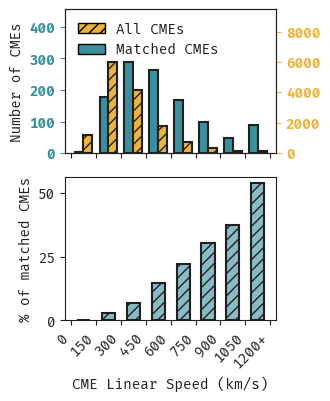

In [26]:
# Now let's look at the CME speeds

data = pd.read_sql("""
SELECT FCHA.*, C.cme_pa, (PHBB.LONDTMIN + PHBB.LONDTMAX) / 2 AS longitude FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN CMES C ON FCHA.cme_id = C.cme_id
INNER JOIN PROCESSED_HARPS_BBOX PHBB ON FCHA.harpnum = PHBB.harpnum AND C.image_timestamp = PHBB.Timestamp
""", conn)

all_cmes = pd.read_sql("SELECT * FROM CMES C WHERE C.cme_date BETWEEN ? AND ?", conn, params=(study_start, study_end))

import warnings
warnings.warn("THE SHAPE OF THIS CHANGES A LOT WHETHER YOU CONSIDER HALO OR NOT")

lasco = pd.read_csv("../data/interim/lasco_cme_database.csv")


data["CME_ID"] = data.apply(lambda x: f"ID{x['cme_id']}", axis=1)
all_cmes["CME_ID"] = all_cmes.apply(lambda x: f"ID{x['cme_id']}", axis=1)

# Merge on CME_ID

data = data.merge(lasco[["CME_ID", "CME_LINEAR_SPEED"]], on="CME_ID", how="left")
all_cmes = all_cmes.merge(lasco[["CME_ID", "CME_LINEAR_SPEED"]], on="CME_ID", how="left")

# Now do distribution of speeds

matched_speeds = data["CME_LINEAR_SPEED"].dropna()
all_speeds = all_cmes["CME_LINEAR_SPEED"].dropna()

fig, axes = plt.subplots(2, figsize=(0.9 * onecolumn, 0.9 * 2 * 0.618 * onecolumn), sharex=True)

ax = axes[0]

bin_size = 150 
bins = np.arange(0, 1200, bin_size)
bins = np.append(bins, 10000)
print(bins)

xticks = bins.copy()
xticks[-1] = xticks[-2] + bin_size

xtick_labels = xticks.astype("str")
xtick_labels[-1] = f"{xticks[-1]}+"


matched_speeds_bin_counts = np.histogram(matched_speeds, bins)[0]
all_speeds_bin_counts = np.histogram(all_speeds, bins)[0]

diff_counts = all_speeds_bin_counts - matched_speeds_bin_counts

center_pos = bins[:-1] + bin_size / 2.0

widths = 0.35 * bin_size
matched_pos = center_pos - widths / 2
all_pos = center_pos + widths / 2

ax.bar(matched_pos, matched_speeds_bin_counts, color=colors["blue"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="")

ax2 = ax.twinx()
ax2.bar(all_pos, all_speeds_bin_counts,  color=colors["yellow"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="///")

# Set the y labels color

ax.tick_params("y", colors=colors["blue"])
ax2.tick_params("y", colors=colors["yellow"])

# And bold

for tick in ax.get_yticklabels():
    tick.set_fontweight("bold")

for tick in ax2.get_yticklabels():
    tick.set_fontweight("bold")

ax.set_ylabel("Number of CMEs")

legend_handles = [
    Patch(facecolor=colors["yellow"], edgecolor="black", label="All CMEs", hatch="///"), 
    Patch(facecolor=colors["blue"], edgecolor="black", label="Matched CMEs")
]

ax.legend(handles=legend_handles, loc="upper left", frameon=False)

ylim1 = ax.get_ylim()
ylim2 = ax2.get_ylim()

ax.set_ylim(ylim1[0], ylim1[1] * 1.5)
ax2.set_ylim(ylim2[0], ylim2[1] * 1.5)

axp = axes[1]

percent_bins = matched_speeds_bin_counts / all_speeds_bin_counts * 100

lighter_blue = darken_lighten_hex_color(colors["blue"], 0.4)
axp.bar(center_pos, percent_bins, color=lighter_blue, edgecolor=colors["black"], linewidth=1.5, width= 1.5 * widths, align="center", zorder=5, hatch="///")

axp.set_xlabel("CME Linear Speed (km/s)")

axp.set_ylabel("% of matched CMEs")

axp.set_xticks(xticks)
axp.set_xticklabels(xtick_labels, rotation=45, ha="right")

# Put axhlines at the center_pos

#for pos in center_pos:
#    axp.axvline(pos, color="black", linestyle="--", zorder=0, alpha=0.3)

ax.set_box_aspect(0.681)
axp.set_box_aspect(0.681)

axp.set_yticks([0, 25, 50])

plt.tight_layout()

plt.savefig("cme_speed_dist.pdf", bbox_inches="tight")

[-90 -75 -45 -15  15  45  75  90] [-90. -60. -30.   0.  30.  60.  90.] [-105  -75  -45  -15   15   45   75  105] ['-90' '-75' '-45' '-15' '15' '45' '75' '90']


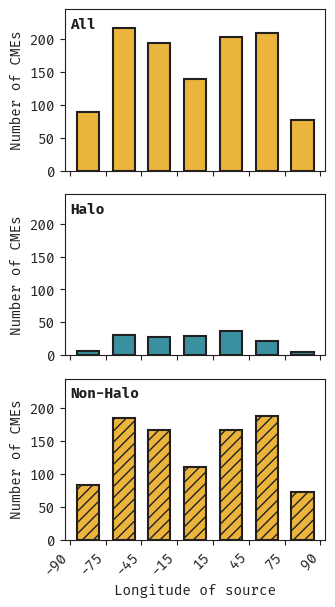

In [28]:
# What if we do longitude distribution but halo on one side and non-halo on the other?

data = pd.read_sql("""
SELECT FCHA.*, C.cme_halo, (PHBB.LONDTMIN + PHBB.LONDTMAX) / 2 AS longitude FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN CMES C ON FCHA.cme_id = C.cme_id
INNER JOIN PROCESSED_HARPS_BBOX PHBB ON FCHA.harpnum = PHBB.harpnum AND C.image_timestamp = PHBB.Timestamp
""", conn)

halo_lons = data[data["cme_halo"] == 1]["longitude"]
nonhalo_lons = data[data["cme_halo"] == 0]["longitude"]
all_lons = data["longitude"]

fig, axes = plt.subplots(3, figsize=(0.9 * onecolumn, 0.9 * 3 * 0.618 * onecolumn), sharex=True, sharey=True)

bin_size = 30
bins = np.arange(bin_size / 2, 90 + bin_size / 2, bin_size)
# Now need to mirror the bins and add it with negative signs
mirror = -bins[::-1]
bins = np.concatenate([mirror, bins]).astype(int)

center_pos = bins[:-1] + bin_size / 2.0

xticks = bins.copy()


# In case the first isn't -90 or last isn't 90 we must add it

if bins[0] != -90:
    bins = np.append(-90, bins)
    start_pos = center_pos[0] - bin_size
    center_pos = np.append(start_pos, center_pos)
    first_tick = xticks[0] - bin_size
    xticks = np.append(first_tick, xticks)
if bins[-1] != 90:
    bins = np.append(bins, 90)
    last_pos = center_pos[-1] + bin_size
    center_pos = np.append(center_pos, last_pos)
    last_tick = xticks[-1] + bin_size
    xticks = np.append(xticks, last_tick)

xtick_labels = xticks.astype("str")
xtick_labels[0] = "-90"
xtick_labels[-1] = "90"

all_counts = np.histogram(all_lons, bins)[0]
halo_counts = np.histogram(halo_lons, bins)[0]
nonhalo_counts = np.histogram(nonhalo_lons, bins)[0]

print(bins, center_pos, xticks, xtick_labels)

widths = 0.618 * bin_size

all_ax = axes[0]
halo_ax = axes[1]
nonhalo_ax = axes[2]

all_ax.bar(center_pos, all_counts, color=colors["yellow"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="")

halo_ax.bar(center_pos, halo_counts, color=colors["blue"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="")

nonhalo_ax.bar(center_pos, nonhalo_counts, color=colors["yellow"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="///")

all_ax.set_ylabel("Number of CMEs")

halo_ax.set_ylabel("Number of CMEs")

nonhalo_ax.set_ylabel("Number of CMEs")

all_ax.set_ylim(0, 1.3 * all_counts.max())
halo_ax.set_ylim(0, 1.3 * halo_counts.max())
nonhalo_ax.set_ylim(0, 1.3 * nonhalo_counts.max())

# Add text labels

all_ax.text(0.02, 0.95, "All", transform=all_ax.transAxes, fontsize=10, va="top", weight="bold")
halo_ax.text(0.02, 0.95, "Halo", transform=halo_ax.transAxes, fontsize=10, va="top", weight="bold")
nonhalo_ax.text(0.02, 0.95, "Non-Halo", transform=nonhalo_ax.transAxes, fontsize=10, va="top", weight="bold")

nonhalo_ax.set_xticks(xticks)
nonhalo_ax.set_xticklabels(xtick_labels, rotation=45, ha="right")

nonhalo_ax.set_xlabel("Longitude of source")

# Set aspect ratios

for axi in axes:
    axi.set_box_aspect(0.618)

plt.tight_layout()

plt.savefig("longitude_distribution.pdf", bbox_inches="tight")

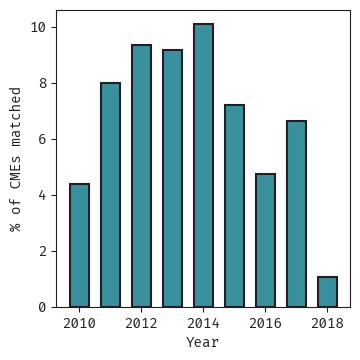

In [254]:
# Percent of all CMEs matched overtime

matched_data = pd.read_sql("""
SELECT C.cme_date FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN CMES C ON FCHA.cme_id = C.cme_id
""", conn)

all_data = pd.read_sql("""
SELECT C.cme_date FROM CMES C
WHERE C.cme_date BETWEEN ? AND ?
""", conn, params=(study_start, study_end))

all_data["cme_date"] = pd.to_datetime(all_data["cme_date"])
matched_data["cme_date"] = pd.to_datetime(matched_data["cme_date"])

# We bin by year

all_data["year"] = all_data["cme_date"].dt.year
matched_data["year"] = matched_data["cme_date"].dt.year

matched_years = matched_data["year"].to_numpy()
all_years = all_data["year"].to_numpy()

bin_size = 1
bins = np.arange(2009.5, 2019.5, bin_size)

all_counts = np.histogram(all_years, bins)[0]
matched_counts = np.histogram(matched_years, bins)[0]

matched_year_counts = matched_counts

percentages = matched_counts / all_counts * 100

fig, ax = plt.subplots(figsize=(onecolumn, onecolumn))

center_pos = bins[:-1] + bin_size / 2.0

widths = 0.618 * bin_size

ax.bar(center_pos, percentages, color=colors["blue"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="")
ax.set_ylabel("% of CMEs matched")
ax.set_xlabel("Year")

ax.set_xticks(np.arange(2010, 2019, 2))

plt.tight_layout()

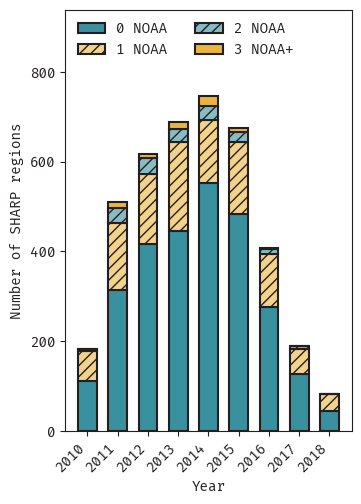

In [247]:
# Ok now I want to see for each year, how's the number of SHARP regions with a particular number of NOAA distributed

data = pd.read_sql("""
WITH n_noaa AS (
SELECT H.harpnum, COALESCE((SELECT COUNT(*) FROM NOAA_HARPNUM_MAPPING NHM WHERE NHM.harpnum = H.harpnum), 0) AS n_noaa FROM HARPS H
)
SELECT H.harpnum, H.start, N.n_noaa FROM HARPS H
INNER JOIN n_noaa N ON N.harpnum = H.harpnum
WHERE H.start > ? AND H.start < ?
""", conn, params=(study_start, study_end))

data["start"] = pd.to_datetime(data["start"])
data["year"] = data["start"].dt.year

# Now we need to do year by year

year_data = []

for year in range(2010, 2019):
    single_year_data = data[data["year"] == year]
    n_noaa = single_year_data["n_noaa"].to_numpy()
    bins = np.arange(-0.5, 3.5, 1)
    bins = np.append(bins, 100)
    total_bin_counts = np.histogram(n_noaa, bins)[0]
    year_data.append(total_bin_counts)

# Now I want on the x axis the years and for each year a series of stacked bars

fig, ax = plt.subplots(figsize=(onecolumn, 1 / 0.618 * onecolumn))

center_pos = np.arange(2010, 2019)

widths = 0.618

# Need five distinct styles
styles = [
    {"facecolor": colors["blue"], "hatch": ""},
    {"facecolor": darken_lighten_hex_color(colors["yellow"], 0.4), "hatch": "///"},
    {"facecolor": darken_lighten_hex_color(colors["blue"], 0.4), "hatch": "///"},
    {"facecolor": colors["yellow"], "hatch": ""},
]

for i, single_year_data in enumerate(year_data):
    bottom = 0
    total = np.sum(single_year_data)
    percents = single_year_data 
    for n_noaa, counts in enumerate(percents):
        ax.bar(center_pos[i], counts, edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, bottom=bottom, **styles[n_noaa])
        bottom += counts

ax.set_xticks(center_pos)
# Rotate the x ticks
ax.set_xticklabels(center_pos, rotation=45, ha="right")

ax.set_xlabel("Year")

ax.set_ylabel("Number of SHARP regions")

# Now let's add a legend

labels = ["0 NOAA", "1 NOAA", "2 NOAA", "3 NOAA+"]

legend_handles = [
    Patch(edgecolor=colors["black"], linewidth=1.5, **styles[i], label=labels[i]) for i in range(4)
]

ax.legend(handles=legend_handles, loc="upper left", frameon=False, ncols=2)

ylim = ax.get_ylim()

ax.set_ylim(0, ylim[1] * 1.2)

ax.set_box_aspect(1/ 0.681)

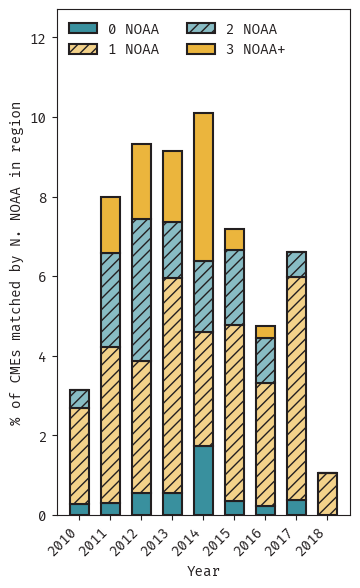

In [190]:
# Percent of all CMEs matched overtime

matched_data = pd.read_sql("""
WITH n_noaa AS (
SELECT H.harpnum, COALESCE((SELECT COUNT(*) FROM NOAA_HARPNUM_MAPPING NHM WHERE NHM.harpnum = H.harpnum), 0) AS n_noaa FROM HARPS H
)
SELECT C.cme_date, N.n_noaa FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN CMES C ON FCHA.cme_id = C.cme_id
INNER JOIN n_noaa N ON N.harpnum = FCHA.harpnum
""", conn)

all_data = pd.read_sql("""
SELECT C.cme_date FROM CMES C
""", conn)

all_data["cme_date"] = pd.to_datetime(all_data["cme_date"])
matched_data["cme_date"] = pd.to_datetime(matched_data["cme_date"])

# We bin by year

all_data["year"] = all_data["cme_date"].dt.year
matched_data["year"] = matched_data["cme_date"].dt.year

# Now we need to do year by year simmilar to above

year_data = []

for year in range(2010, 2019):
    single_year_data = matched_data[matched_data["year"] == year]
    n_noaa = single_year_data["n_noaa"].to_numpy()
    bins = np.arange(-0.5, 3.5, 1)
    bins = np.append(bins, 100)
    matched_bin_counts = np.histogram(n_noaa, bins)[0]

    total_n_cme_in_year = all_data[all_data["year"] == year].shape[0]

    percentages = matched_bin_counts / total_n_cme_in_year * 100
    year_data.append(percentages)

# Now I want on the x axis the years and for each year a series of stacked bars

# Need five distinct styles
styles = [
    {"facecolor": colors["blue"], "hatch": ""},
    {"facecolor": darken_lighten_hex_color(colors["yellow"], 0.4), "hatch": "///"},
    {"facecolor": darken_lighten_hex_color(colors["blue"], 0.4), "hatch": "///"},
    {"facecolor": colors["yellow"], "hatch": ""},
]

fig, ax = plt.subplots(figsize=(onecolumn, 1 / 0.618 * onecolumn))

center_pos = np.arange(2010, 2019)

widths = 0.618

for i, single_year_data in enumerate(year_data):
    bottom = 0
    for n_noaa, counts in enumerate(single_year_data):
        ax.bar(center_pos[i], counts, edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, bottom=bottom, **styles[n_noaa])
        bottom += counts

ax.set_xticks(center_pos)

# Rotate the x ticks
ax.set_xticklabels(center_pos, rotation=45, ha="right")

ax.set_xlabel("Year")

ax.set_ylabel("% of CMEs matched by N. NOAA in region")

# Now let's add a legend

labels = ["0 NOAA", "1 NOAA", "2 NOAA", "3 NOAA+"]

legend_handles = [
    Patch(edgecolor=colors["black"], linewidth=1.5, **styles[i], label=labels[i]) for i in range(4)
]

ax.legend(handles=legend_handles, loc="upper left", frameon=False, ncols=2)

ylim = ax.get_ylim()

ax.set_ylim(0, ylim[1] * 1.2)

plt.tight_layout()


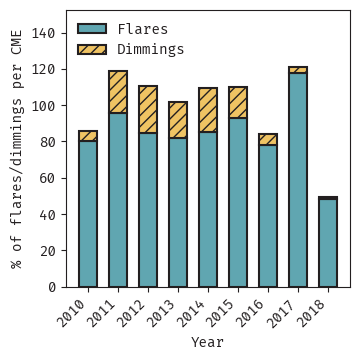

In [248]:
# Ok, what about dividing the number of flares and dimmings per year by the number of CMEs

flares_data = pd.read_sql("""
SELECT F.flare_date FROM FLARES F
WHERE F.flare_date BETWEEN ? AND ?
""", conn, params=(study_start, study_end))

dimmings_data = pd.read_sql("""
SELECT D.dimming_peak_date AS dimming_date FROM DIMMINGS D
WHERE D.dimming_peak_date BETWEEN ? AND ?
""", conn, params=(study_start, study_end))

cmes_data = pd.read_sql("""
SELECT C.cme_date FROM CMES C
WHERE C.cme_date BETWEEN ? AND ?
""", conn, params=(study_start, study_end))

flares_data["flare_date"] = pd.to_datetime(flares_data["flare_date"])
dimmings_data["dimming_date"] = pd.to_datetime(dimmings_data["dimming_date"])
cmes_data["cme_date"] = pd.to_datetime(cmes_data["cme_date"])

flares_data["year"] = flares_data["flare_date"].dt.year
dimmings_data["year"] = dimmings_data["dimming_date"].dt.year
cmes_data["year"] = cmes_data["cme_date"].dt.year

# Now we need to do year by year simmilar to above
years_data = []

for year in range(2010, 2019):
    single_year_flares = flares_data[flares_data["year"] == year]
    single_year_dimmings = dimmings_data[dimmings_data["year"] == year]
    single_year_cmes = cmes_data[cmes_data["year"] == year]

    n_flares = single_year_flares.shape[0]
    n_dimmings = single_year_dimmings.shape[0]
    n_cmes = single_year_cmes.shape[0]

    flares_percent = n_flares / n_cmes * 100
    dimmings_percent = n_dimmings / n_cmes * 100

    years_data.append((flares_percent, dimmings_percent))

# Now I want on the x axis the years and for each year a series of stacked bars

# Need two distinct styles

styles = [
    {"facecolor": darken_lighten_hex_color(colors["blue"], 0.2), "hatch": ""},
    {"facecolor": darken_lighten_hex_color(colors["yellow"], 0.2), "hatch": "///"},
]

fig, ax = plt.subplots(figsize=(onecolumn, onecolumn))
/
center_pos = np.arange(2010, 2019)

widths = 0.618

for i, single_year_data in enumerate(years_data):
    bottom = 0
    for n_noaa, counts in enumerate(single_year_data):
        ax.bar(center_pos[i], counts, edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, bottom=bottom, **styles[n_noaa])
        bottom += counts

ax.set_xticks(center_pos)

# Rotate the x ticks
ax.set_xticklabels(center_pos, rotation=45, ha="right")

ax.set_xlabel("Year")

ax.set_ylabel("% of flares/dimmings per CME")

# Now let's add a legend

labels = ["Flares", "Dimmings"]

legend_handles = [
    Patch(edgecolor=colors["black"], linewidth=1.5, **styles[i], label=labels[i]) for i in range(2)
]

ax.legend(handles=legend_handles, loc="upper left", frameon=False, ncols=1)

ylim = ax.get_ylim()

ax.set_ylim(0, ylim[1] * 1.2)

plt.tight_layout()

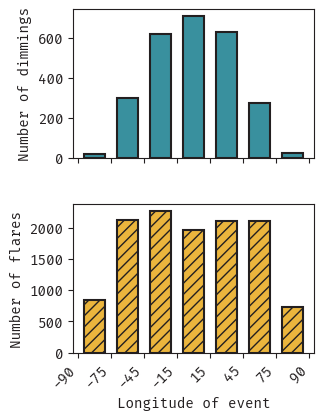

In [30]:
flares_data = pd.read_sql("""
SELECT F.flare_lon FROM FLARES F
WHERE F.flare_date BETWEEN ? AND ?
""", conn, params=(study_start, study_end))

dimmings_data = pd.read_sql("""
SELECT D.dimming_lon FROM DIMMINGS D
WHERE D.dimming_peak_date BETWEEN ? AND ?
""", conn, params=(study_start, study_end))

fig, axes = plt.subplots(2,figsize=(0.9 * onecolumn, 0.9 * 2 * 0.681 * onecolumn), sharex=True)

bin_size = 30

bins = np.arange(bin_size / 2, 90 + bin_size / 2, bin_size)
# Now need to mirror the bins and add it with negative signs
mirror = -bins[::-1]
bins = np.concatenate([mirror, bins])

center_pos = bins[:-1] + bin_size / 2.0

xticks = bins.copy()


# In case the first isn't -90 or last isn't 90 we must add it

if bins[0] != -90:
    bins = np.append(-90, bins)
    start_pos = center_pos[0] - bin_size
    center_pos = np.append(start_pos, center_pos)
    first_tick = xticks[0] - bin_size
    xticks = np.append(first_tick, xticks)
if bins[-1] != 90:
    bins = np.append(bins, 90)
    last_pos = center_pos[-1] + bin_size
    center_pos = np.append(center_pos, last_pos)
    last_tick = xticks[-1] + bin_size
    xticks = np.append(xticks, last_tick)

xticks = xticks.astype(int)

xtick_labels = xticks.astype("str")
xtick_labels[0] = "-90"
xtick_labels[-1] = "90"

dimming_counts = np.histogram(dimmings_data["dimming_lon"], bins)[0]
flare_counts = np.histogram(flares_data["flare_lon"], bins)[0]

widths = 0.618 * bin_size

axes[0].bar(center_pos, dimming_counts, color=colors["blue"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="")
axes[1].bar(center_pos, flare_counts, color=colors["yellow"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="///")

axes[0].set_ylabel("Number of dimmings")
axes[1].set_ylabel("Number of flares")

axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xtick_labels, rotation=45, ha="right")

axes[0].set_box_aspect(0.618)
axes[1].set_box_aspect(0.618)

axes[1].set_xlabel("Longitude of event")

#axes[1].set_xlim(-76, 76)

plt.tight_layout()

plt.savefig("longitude_distribution_flare_dimming.pdf", bbox_inches="tight")

(0.0, 273.41999999999996)

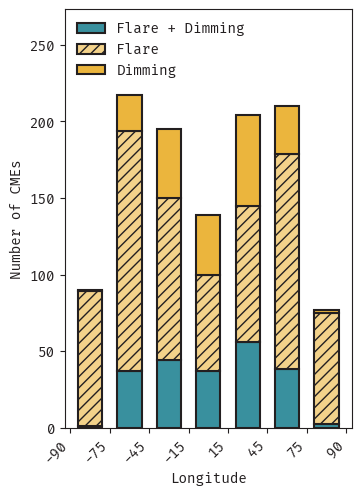

In [218]:
# What if we do longitude distribution but halo on one side and non-halo on the other?

data = pd.read_sql("""
SELECT FCHA.*, (PHBB.LONDTMIN + PHBB.LONDTMAX) / 2 AS longitude FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN CMES C ON FCHA.cme_id = C.cme_id
INNER JOIN PROCESSED_HARPS_BBOX PHBB ON FCHA.harpnum = PHBB.harpnum AND C.image_timestamp = PHBB.Timestamp
""", conn)

bin_size = 30
bins = np.arange(bin_size / 2, 90 + bin_size / 2, bin_size)
# Now need to mirror the bins and add it with negative signs
mirror = -bins[::-1]
bins = np.concatenate([mirror, bins]).astype(int)

center_pos = bins[:-1] + bin_size / 2.0

xticks = bins.copy()


# In case the first isn't -90 or last isn't 90 we must add it

if bins[0] != -90:
    bins = np.append(-90, bins)
    start_pos = center_pos[0] - bin_size
    center_pos = np.append(start_pos, center_pos)
    first_tick = xticks[0] - bin_size
    xticks = np.append(first_tick, xticks)
if bins[-1] != 90:
    bins = np.append(bins, 90)
    last_pos = center_pos[-1] + bin_size
    center_pos = np.append(center_pos, last_pos)
    last_tick = xticks[-1] + bin_size
    xticks = np.append(xticks, last_tick)

xtick_labels = xticks.astype("str")
xtick_labels[0] = "-90"
xtick_labels[-1] = "90"

bins_data = []

for i, bin_left in enumerate(bins[:-1]):
    bin_right = bins[i + 1]
    single_bin_data = data[(data["longitude"] >= bin_left) & (data["longitude"] < bin_right)]

    # Now need the counts by verification_score
    lev1 = single_bin_data[single_bin_data["verification_score"] == 1].shape[0]
    lev2 = single_bin_data[single_bin_data["verification_score"] == 2].shape[0]
    lev3 = single_bin_data[single_bin_data["verification_score"] == 3].shape[0]
    lev4 = single_bin_data[single_bin_data["verification_score"] == 4].shape[0]
    lev5 = single_bin_data[single_bin_data["verification_score"] == 5].shape[0]

    bins_data.append((lev1 + lev3, lev2 + lev4, lev5))

# Now I want on the x axis the bins and for each year a series of stacked bars

# Need three distinct styles

styles = [
    {"facecolor": colors["blue"], "hatch": ""},
    {"facecolor": darken_lighten_hex_color(colors["yellow"], 0.4), "hatch": "///"},
    {"facecolor": colors["yellow"], "hatch": ""},
]

fig, ax = plt.subplots(figsize=(onecolumn, 1/ 0.681 * onecolumn))

for i, single_bin_data in enumerate(bins_data):
    bottom = 0
    for n_noaa, counts in enumerate(single_bin_data):
        ax.bar(center_pos[i], counts, edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, bottom=bottom, **styles[n_noaa])
        bottom += counts

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45, ha="right")

ax.set_xlabel("Longitude")

ax.set_ylabel("Number of CMEs")

# Now let's add a legend

labels = ["Flare + Dimming", "Flare", "Dimming"]

legend_handles = [
    Patch(edgecolor=colors["black"], linewidth=1.5, **styles[i], label=labels[i]) for i in range(3)
]
ax.legend(handles=legend_handles, loc="upper left", frameon=False, ncols=1)

ylim = ax.get_ylim()

ax.set_ylim(0, ylim[1] * 1.2)


[    0   150   300   450   600   750   900  1050 10000]


Text(0, 0.5, 'Verification Score')

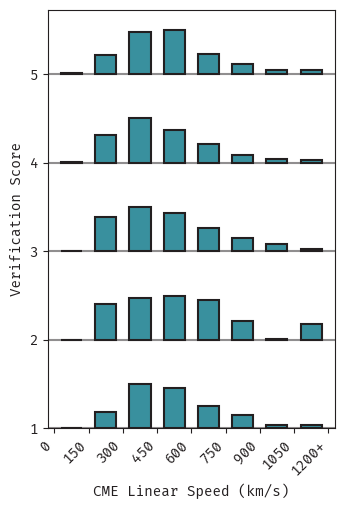

In [229]:
# Let me do CME speed vs verification score

data = pd.read_sql("""
SELECT FCHA.*, C.cme_pa, (PHBB.LONDTMIN + PHBB.LONDTMAX) / 2 AS longitude FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN CMES C ON FCHA.cme_id = C.cme_id
INNER JOIN PROCESSED_HARPS_BBOX PHBB ON FCHA.harpnum = PHBB.harpnum AND C.image_timestamp = PHBB.Timestamp
""", conn)

lasco = pd.read_csv("../data/interim/lasco_cme_database.csv")


data["CME_ID"] = data.apply(lambda x: f"ID{x['cme_id']}", axis=1)

# Merge on CME_ID

data = data.merge(lasco[["CME_ID", "CME_LINEAR_SPEED"]], on="CME_ID", how="left")

fig, ax = plt.subplots(figsize=(onecolumn, 1/ 0.681 * onecolumn))

# For each verification score, let's do a small histogram


bin_size = 150 
bins = np.arange(0, 1200, bin_size)
bins = np.append(bins, 10000)
print(bins)

xticks = bins.copy()
xticks[-1] = xticks[-2] + bin_size

xtick_labels = xticks.astype("str")
xtick_labels[-1] = f"{xticks[-1]}+"


center_pos = bins[:-1] + bin_size / 2.0

widths = 0.618 * bin_size

for verif_level in sorted(data["verification_score"].unique()):
    single_data = data[data["verification_score"] == verif_level]

    counts = np.histogram(single_data["CME_LINEAR_SPEED"], bins=bins)[0]

    counts = counts / np.max(counts) * 0.5

    ax.bar(center_pos, counts, color=colors["blue"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="", bottom=verif_level)

    ax.axhline(verif_level, color=colors["black"], linestyle="-", zorder=0, alpha=0.5)


ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45, ha="right")

ax.set_xlabel("CME Linear Speed (km/s)")

ax.set_ylabel("Verification Score")


[    0   150   300   450   600   750   900  1050 10000]


Text(0, 0.5, 'Verification Score')

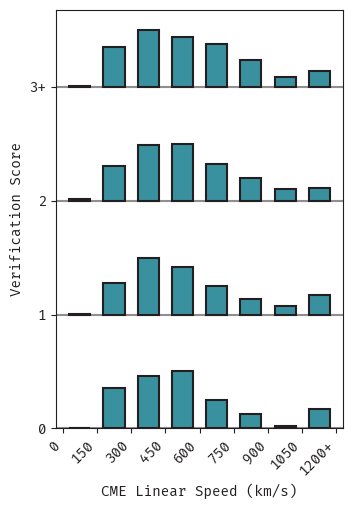

In [251]:

# Let me do CME speed vs verification score

data = pd.read_sql("""
WITH n_noaa AS (
SELECT H.harpnum, COALESCE((SELECT COUNT(*) FROM NOAA_HARPNUM_MAPPING NHM WHERE NHM.harpnum = H.harpnum), 0) AS n_noaa FROM HARPS H
)
SELECT FCHA.*, C.cme_pa, N.n_noaa FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN CMES C ON FCHA.cme_id = C.cme_id
INNER JOIN n_noaa N ON N.harpnum = FCHA.harpnum
""", conn)

lasco = pd.read_csv("../data/interim/lasco_cme_database.csv")


data["CME_ID"] = data.apply(lambda x: f"ID{x['cme_id']}", axis=1)

# Merge on CME_ID

data = data.merge(lasco[["CME_ID", "CME_LINEAR_SPEED"]], on="CME_ID", how="left")

fig, ax = plt.subplots(figsize=(onecolumn, 1/ 0.681 * onecolumn))

# For each verification score, let's do a small histogram


bin_size = 150 
bins = np.arange(0, 1200, bin_size)
bins = np.append(bins, 10000)
print(bins)

xticks = bins.copy()
xticks[-1] = xticks[-2] + bin_size

xtick_labels = xticks.astype("str")
xtick_labels[-1] = f"{xticks[-1]}+"


center_pos = bins[:-1] + bin_size / 2.0

widths = 0.618 * bin_size

noaa_bins = [-0.5, 0.5, 1.5, 2.5, 100]
noaa_locs = [0, 1, 2, 3]
noaa_labels = ["0", "1", "2", "3+"]

for i, noaa_bin_left in enumerate(noaa_bins[:-1]):
    noaa_bin_right = noaa_bins[i + 1]
    single_data = data[data["n_noaa"].between(noaa_bin_left, noaa_bin_right)]

    bottom = noaa_locs[i]

    counts = np.histogram(single_data["CME_LINEAR_SPEED"], bins=bins)[0]

    counts = counts / np.max(counts) * 0.5

    ax.bar(center_pos, counts, color=colors["blue"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="", bottom=bottom)

    ax.axhline(bottom, color=colors["black"], linestyle="-", zorder=0, alpha=0.5)


ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45, ha="right")

ax.set_yticks(noaa_locs)
ax.set_yticklabels(noaa_labels)

ax.set_xlabel("CME Linear Speed (km/s)")

ax.set_ylabel("Verification Score")


Text(0, 0.5, 'Verification Score')

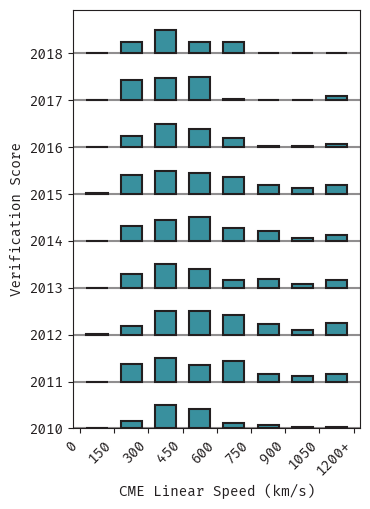

In [255]:
# Let me do CME speed vs verification score

data = pd.read_sql("""
SELECT FCHA.*, C.cme_date, (PHBB.LONDTMIN + PHBB.LONDTMAX) / 2 AS longitude FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN CMES C ON FCHA.cme_id = C.cme_id
INNER JOIN PROCESSED_HARPS_BBOX PHBB ON FCHA.harpnum = PHBB.harpnum AND C.image_timestamp = PHBB.Timestamp
""", conn)

lasco = pd.read_csv("../data/interim/lasco_cme_database.csv")


data["CME_ID"] = data.apply(lambda x: f"ID{x['cme_id']}", axis=1)

# Merge on CME_ID

data = data.merge(lasco[["CME_ID", "CME_LINEAR_SPEED"]], on="CME_ID", how="left")

data["cme_date"] = pd.to_datetime(data["cme_date"])
data["year"] = data["cme_date"].dt.year

fig, ax = plt.subplots(figsize=(onecolumn, 1/ 0.681 * onecolumn))

# For each verification score, let's do a small histogram


bin_size = 150 
bins = np.arange(0, 1200, bin_size)
bins = np.append(bins, 10000)

xticks = bins.copy()
xticks[-1] = xticks[-2] + bin_size

xtick_labels = xticks.astype("str")
xtick_labels[-1] = f"{xticks[-1]}+"


center_pos = bins[:-1] + bin_size / 2.0

widths = 0.618 * bin_size

yearly_counts = []

for year in sorted(np.arange(2010, 2019)):
    single_data = data[data["year"] == year]

    counts = np.histogram(single_data["CME_LINEAR_SPEED"], bins=bins)[0]

    yearly_counts.append(counts)

    counts = counts / np.max(counts) * 0.5

    ax.bar(center_pos, counts, color=colors["blue"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="", bottom=year)

    ax.axhline(year, color=colors["black"], linestyle="-", zorder=0, alpha=0.5)


ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45, ha="right")

ax.set_xlabel("CME Linear Speed (km/s)")

ax.set_ylabel("Verification Score")


[7.27157598 5.64437515 4.91591871 5.71484092 5.899814   5.68701145
 7.4659258  8.85405602 9.31178975]


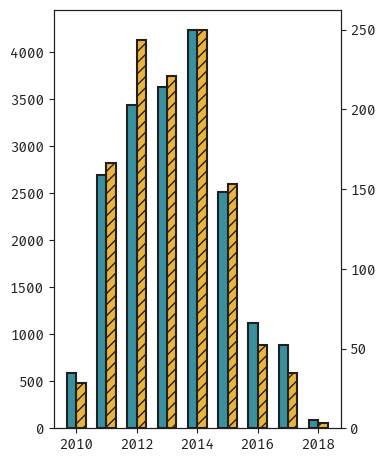

In [261]:
calculated_counts = []

for i, year_single_counts in enumerate(yearly_counts):
    year_single_counts = np.array(year_single_counts)
    count = np.sum(percent_bins * year_single_counts)

    calculated_counts.append(count)

matched_year_counts

fig, ax = plt.subplots(figsize=(onecolumn, 1/ 0.681 * onecolumn))

center_pos = np.arange(2010, 2019)

widths = 0.618 / 2

matched_pos = center_pos - widths / 2
calculated_pos = center_pos + widths / 2

ax2 = ax.twinx()
ax2.bar(matched_pos, matched_year_counts, color=colors["blue"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="")
ax.bar(calculated_pos, calculated_counts, color=colors["yellow"], edgecolor=colors["black"], linewidth=1.5, width=widths, align="center", zorder=5, hatch="///")

print(matched_year_counts / calculated_counts * 100)